<a href="https://colab.research.google.com/github/vedantdave77/project.Orca/blob/master/Time_Series_Prediction_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[Vedant Dave](https://vedantdave117.com/)** | *vedantdave77@gmail.com*

### Primary Goal : 
My Primary goal is to understand RNN by practice. So, I will try to generate some data and then apply RNN, to get prediction about the future data using time-series Prediction.

### Import Libraries.


In [75]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

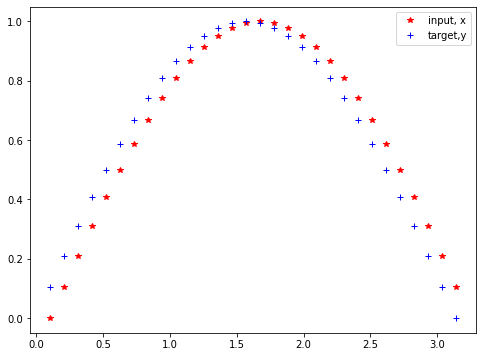

In [76]:
plt.figure(figsize=(8,6))

# No of points for batch data
seq_length = 30

# generate data points with equal space
time_steps = np.linspace(0,np.pi, seq_length +1)  # 31 data point contains 30 time steps.
data = np.sin(time_steps)
data.resize((seq_length +1,1)) # size becomes (seq_length,1) 

# seperate data for use (two steped input)
x = data[:-1]  # except last data-point        # 30 datapoint for x
y = data[1:]   # except first data-point       # 30 datapoint for y

# display data
plt.plot(time_steps[1:],x,'r*',label = 'input, x')
plt.plot(time_steps[1:],y,'b+',label = 'target,y')
plt.legend(loc = 'best')
plt.show()

### RNN Architecture
Here, I am using PyTorch and from documentation we can see theat it takes some parameters as input and they are:
- input_size – The number of expected features in the input x

- hidden_size – The number of features in the hidden state h

- num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. Default: 1

- nonlinearity – The non-linearity to use. Can be either 'tanh' or 'relu'. Default: 'tanh'

- bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True

- batch_first – If True, then the input and output tensors are provided as (batch, seq, feature). Default: False

- dropout – If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout. Default: 0

- bidirectional – If True, becomes a bidirectional RNN. Default: False

In [85]:
# generate architecute
class RNN(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, n_layers): # do not use default para now.
    super(RNN, self).__init__()
    
    # generate parameter values.
    self.hidden_dim = hidden_dim
    self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first = True) # here, I use batch_first = True, means.. i/p and o/p will be the batch_size.
    self.fc = nn.Linear(hidden_dim, output_size) # fully connected layer, with linear seperation

  def forward(self,x, hidden):
    batch_size = x.size(0) 
    # rnn output
    r_out, hidden = self.rnn(x,hidden)     # take batch_size arg. automatically...
    r_out = r_out.view(-1,self.hidden_dim)
    output = self.fc(r_out)
    return output, hidden
  

### Sample test: 
To varify network architecture before training

In [86]:
test_rnn = RNN(input_size=1, output_size=1, hidden_dim= 10, n_layers= 2)

# generate random data
time_steps = np.linspace(0,np.pi,seq_length)
data = np.sin(time_steps)
data.resize((seq_length,1))

# test input size
test_input = torch.Tensor(data).unsqueeze(0)
print('Input size: ',test_input.size())

# test rnn size
test_out, test_hid = test_rnn(test_input, None) # initial hidden state is None. 
print('Hidden state size: ' , test_hid.size())
print('Output size: ' , test_out.size())

Input size:  torch.Size([1, 30, 1])
Hidden state size:  torch.Size([2, 1, 10])
Output size:  torch.Size([30, 1])


- Input size = (batch, sequnce, features) because of batch_first = True
- Hidden size = (n_layers, batch_size, hidden_dim)
- Output size = (batch_size*seq_length,output_dim)
 


### Training the RNN


In [87]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


### Loss and Optimization

This is a regression problem: can we train an RNN to accurately predict the next data point, given a current data point?

>* The data points are coordinate values, so to compare a predicted and ground_truth point, we'll use a regression loss: the mean squared error.
* It's typical to use an Adam optimizer for recurrent models.

In [88]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

### Training Function:
This function will takes each required parameters as defined above, and return us trained rnn. I also include loss and optimizer in algorithm. 

#### Importannt:
In starting our hidden state will be zero, but after time step, we need to use the generated hidden state as next hidden state. So, I will detach the hidden data and reuse it iteratively. 


In [89]:
# Training of RNN
def train(rnn, n_steps, print_every):
  hidden = None                      # initial hidden state
  for batch_i, step in enumerate(range(n_steps)):
    # ==========================================================================
    ### DATA ###
    # generate data 
    time_steps = np.linspace(step * np.pi, (step+1) *np.pi, seq_length +1)
    data = np.sin(time_steps)
    data.resize((seq_length+1,1))      # input_size = 1

    # define data
    x = data[:-1]
    y = data[1:]

    # convert data to tnesor
    x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
    y_tensor = torch.Tensor(y)

    # ==========================================================================
    ### FLOW OF RNN ###
    #output from rnn
    prediction, hidden = rnn(x_tensor,hidden)

    # detach hidden state from algorithm, so we do not need to consider it for back propogation
    hidden = hidden.data

    #calculating loss
    loss = criterion(prediction,y_tensor)
    # zero gradients
    optimizer.zero_grad()

    # perform backprop and update weights
    loss.backward()
    optimizer.step()


    # ==========================================================================
    ### VISUALIZATION ###
    # display loss and prediction for analysis purpose
    if batch_i % print_every == 0:
      print('Loss: ',loss.item())
      plt.plot(time_steps[1:], x, 'r+', label= 'Input')
      plt.plot(time_steps[1:],prediction.data.numpy().flatten(),'g*',label = "Prediction")
      plt.legend(loc = 'best')
      plt.show()
      print("<<--------NEXT----------->>")
  return rnn

# Prediction (Time-Series)
Time-series prediction can be applied to many tasks. Think about weather forecasting or predicting the ebb and flow of stock market prices. we can even try to generate predictions much further in the future than just one time step!


Loss:  0.49605461955070496


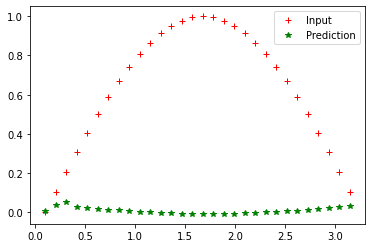

<<--------NEXT----------->>
Loss:  0.039165060967206955


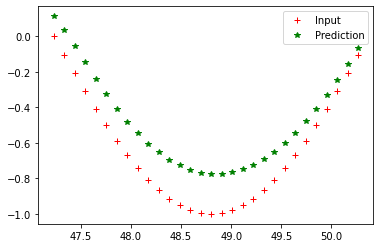

<<--------NEXT----------->>
Loss:  0.00516876857727766


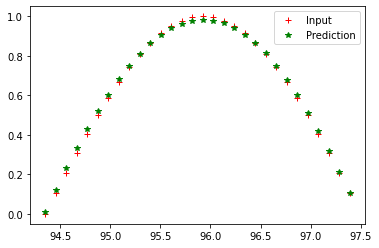

<<--------NEXT----------->>
Loss:  0.002430707449093461


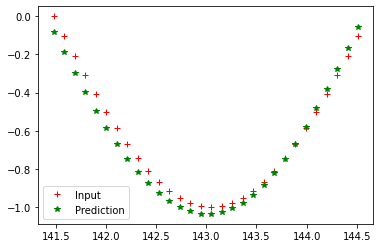

<<--------NEXT----------->>
Loss:  0.0003315472276881337


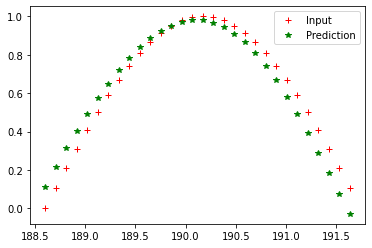

<<--------NEXT----------->>


In [90]:
# train rnn and monitor result
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)

In [ ]:
# Keep Learning, Enjoy Empowering